# SA, dwave-neal

- [SA](https://qiita.com/ShataKurashi/items/c0c6044e97fa9e4a9471#:~:text=%E7%84%BC%E3%81%8D%E3%81%AA%E3%81%BE%E3%81%97%E6%B3%95%EF%BC%88%E3%82%84%E3%81%8D%E3%81%AA%E3%81%BE%E3%81%97,%E3%81%A6%E3%80%81%E3%82%88%E3%81%84%E8%BF%91%E4%BC%BC%E3%82%92%E4%B8%8E%E3%81%88%E3%82%8B%E3%80%82)
- [組み合わせ最適問題に対するSA法　中野秀男・中西義郎](http://www.orsj.or.jp/~archive/pdf/bul/Vol.31_01_043.pdf)

In [1]:
import sys
print(sys.path)

['/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


In [12]:
import pandas as pd 
import numpy as np
from scipy.special import comb
import math
from neal import SimulatedAnnealingSampler
from pyqubo import Array, Constraint, Placeholder, solve_qubo
import itertools
import random
import matplotlib.pyplot as plt
import time

### 解析用データ作成

（3年間骨肉腫に罹患しない）事象と各特徴量とのP値を計算する。
- Osteogenic sarcoma data:骨肉腫
- LI:リンパ球浸出
- AOP:類骨病理学

In [3]:
ost16 = pd.read_csv("../input/ost16.csv", sep=',', index_col=0)
ost16.shape

(16, 4)

In [4]:
#indexを振り直す
ost16 = ost16.reset_index(drop=True)

In [5]:
t_list = []
t_list.append(sum(ost16['Y']))
print(t_list)
t_list.append(np.dot(ost16['Y'], ost16['LI']))
t_list.append(np.dot(ost16['Y'], ost16['SEX']))
t_list.append(np.dot(ost16['Y'], ost16['AOP']))

[14]


In [6]:
t_list#Y, LI, SEX, AOP

[14, 9, 9, 8]

In [7]:
t_list[-4]

14

### t_init = 1e4, reversed(range(1, int(t_init)))

In [47]:
for x in range(0, 5)[::-1]:
    print(x)

4
3
2
1
0


In [65]:
def each_energy(y_sample, t1): #毎回のmaskとyが引数、合致度合いの計算を行う
    energy_except_LI = (np.dot(ost16['SEX'], y_sample)-t_list[2])**2 + (np.dot(ost16['AOP'], y_sample) - t_list[3])**2 + (sum(y_sample) - t_list[1])**2
    energy_LI = (np.dot(ost16['LI'], y_sample) - t1)**2
    return energy_except_LI + energy_LI

In [66]:
# 処理前の時刻
t1 = time.time() 

In [67]:
%%timeit

y_list_num = {}
y_list_variation = {}
each_energy_list = {}
t_init = 1e3 #1000
y_sample = ost16['Y'].copy()

for t1 in range(0, ost16.shape[0]+1):
    y_list_num[t1] = 0
    y_list_variation[t1] = []
    each_energy_list[t1] = []
    
    for T in reversed(range(1, int(t_init))):
        t = T/100
        i = random.choice([i for i in range(ost16.shape[0]) if y_sample[i]==0])
        j = random.choice([j for j in range(ost16.shape[0]) if y_sample[j]==1])
        
        y_sample[i] = 1 - y_sample[i]
        y_sample[j] = 1 - y_sample[j]
        
        each_energy_list[t1].append(each_energy(y_sample, t1))
        
        if each_energy_list[t1][-1] == 0:#エネルギー合計が0
            y_list_num[t1] += 1
            y_list_variation[t1].append(y_sample)
            
        elif len(each_energy_list[t1]) >= 2: #each_energy_listに他の要素が入っていたら    
            if np.random.rand() >= np.exp((each_energy_list[t1][-2]-each_energy_list[t1][-1])/t):
                y_sample[i] = 1 - y_sample[i]
                y_sample[j] = 1 - y_sample[j]
                
        else:#エネルギー合計が0でなく、each_energy_listに要素が入っていない場合
            y_sample[i] = 1 - y_sample[i]
            y_sample[j] = 1 - y_sample[j]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp


12.8 s ± 127 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
# 処理後の時刻
t2 = time.time()

# 経過時間を表示
elapsed_time = t2-t1
print(f"経過時間：{elapsed_time}秒")

経過時間：102.68013739585876秒


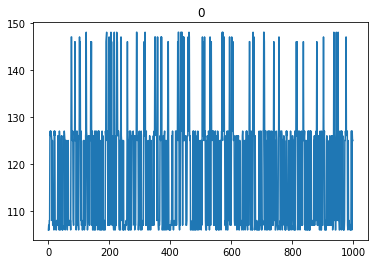

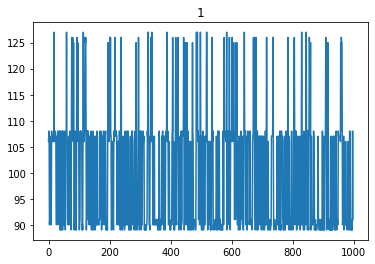

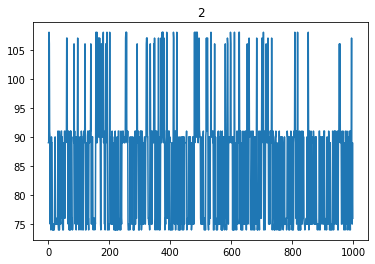

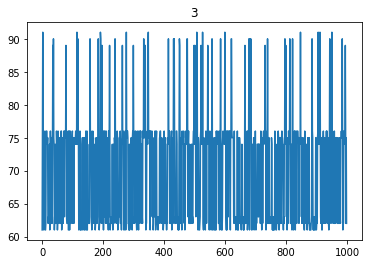

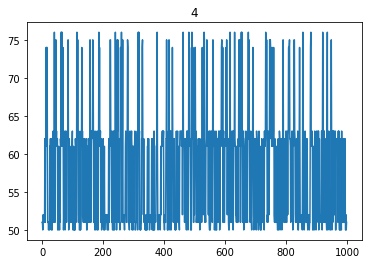

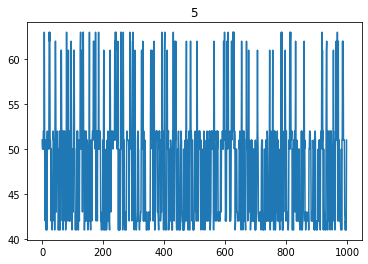

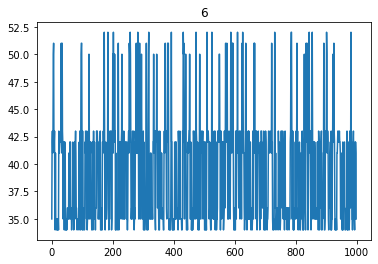

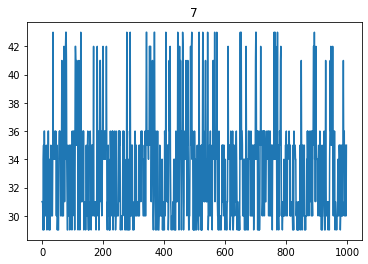

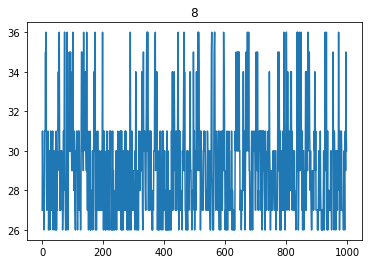

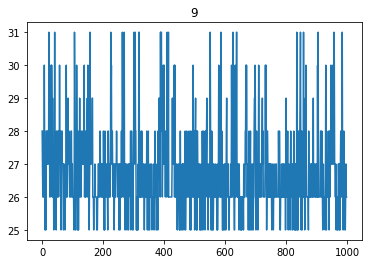

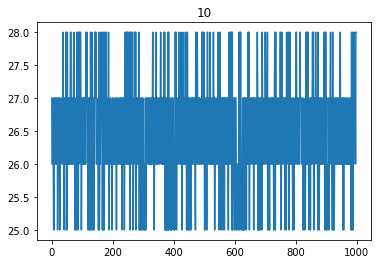

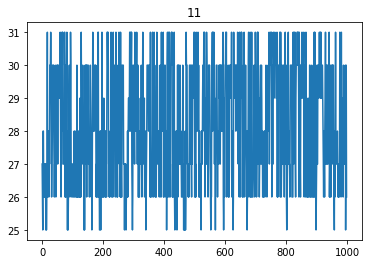

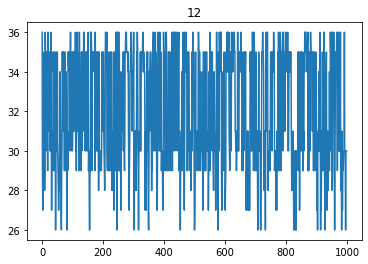

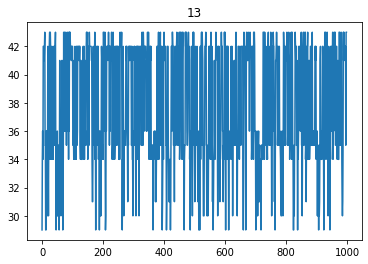

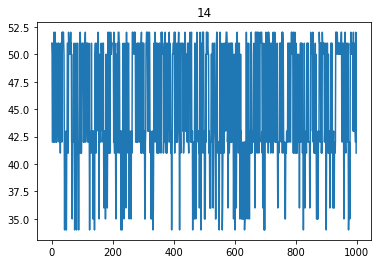

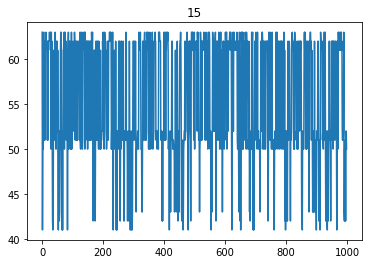

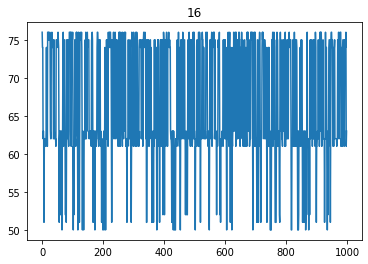

In [69]:
for t1 in range(0, ost16.shape[0]+1):
    plt.plot(each_energy_list[t1])
    plt.title(t1)
    plt.show()

In [70]:
#目標：d-wave nealと同じ結果を出す
y_list_num

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0}

In [60]:
# 処理前の時刻
t1 = time.time() 

In [61]:
%%timeit

y_list_num = {}
y_list_variation = {}
each_energy_list = {}
t_init = 1e4 #10000
y_sample = ost16['Y'].copy()

for t1 in range(0, ost16.shape[0]+1):
    y_list_num[t1] = 0
    y_list_variation[t1] = []
    each_energy_list[t1] = []
    
    for T in reversed(range(1, int(t_init), 40)):
        t = T /500
        i = random.choice([i for i in range(ost16.shape[0]) if y_sample[i]==0])
        j = random.choice([j for j in range(ost16.shape[0]) if y_sample[j]==1])
        
        y_sample[i] = 1 - y_sample[i]
        y_sample[j] = 1 - y_sample[j]
        
        each_energy_list[t1].append(each_energy(y_sample, t1))
        
        if each_energy_list[t1][-1] == 0:#エネルギー合計が0
            y_list_num[t1] += 1
            y_list_variation[t1].append(y_sample)
            
        elif len(each_energy_list[t1]) >= 2: #each_energy_listに他の要素が入っていたら    
            if np.random.rand() >= np.exp((each_energy_list[t1][-2]-each_energy_list[t1][-1])/t):
                y_sample[i] = 1 - y_sample[i]
                y_sample[j] = 1 - y_sample[j]
                
        else:#エネルギー合計が0でなく、each_energy_listに要素が入っていない場合
            y_sample[i] = 1 - y_sample[i]
            y_sample[j] = 1 - y_sample[j]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp


3.17 s ± 48.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
# 処理後の時刻
t2 = time.time()

# 経過時間を表示
elapsed_time = t2-t1
print(f"経過時間：{elapsed_time}秒")

経過時間：25.340702295303345秒


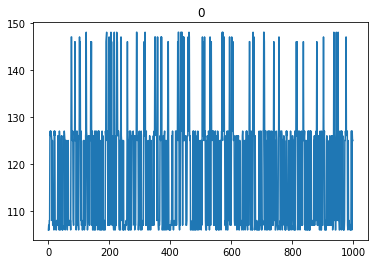

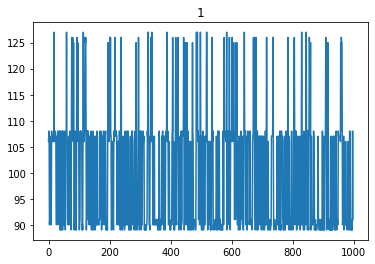

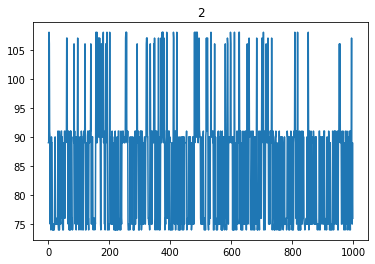

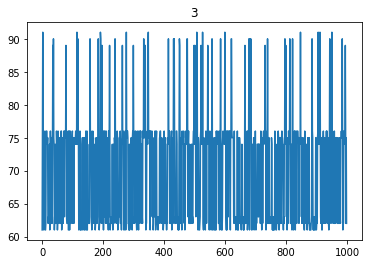

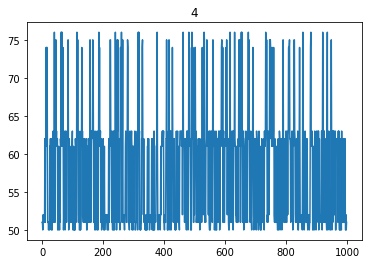

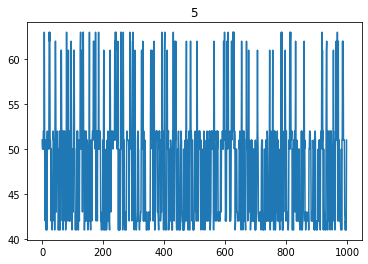

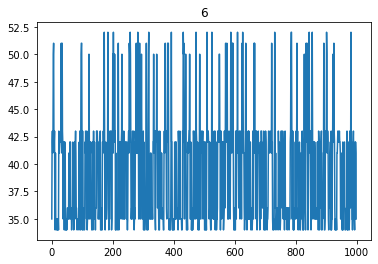

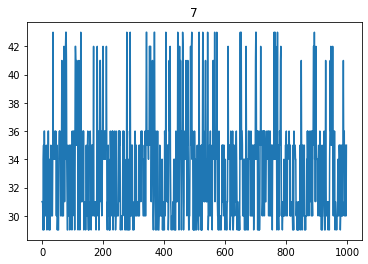

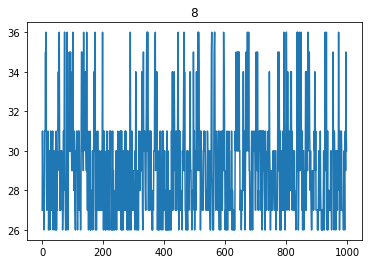

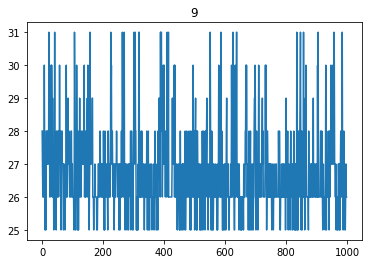

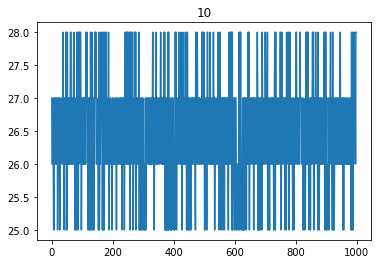

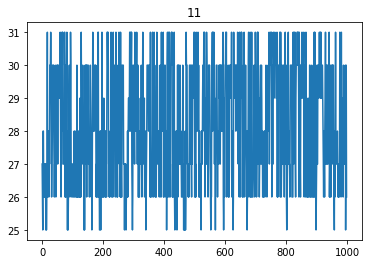

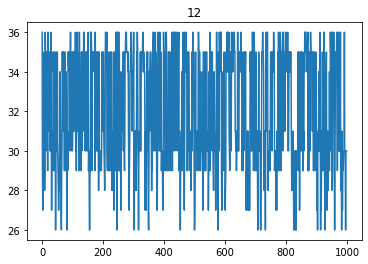

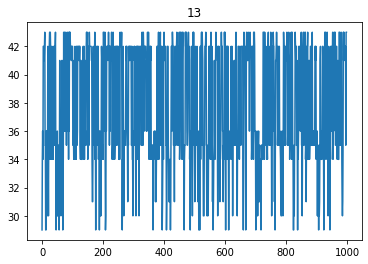

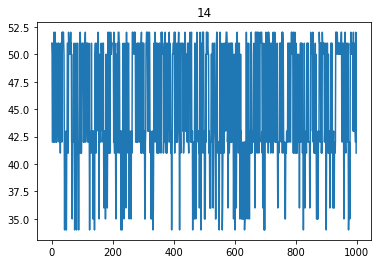

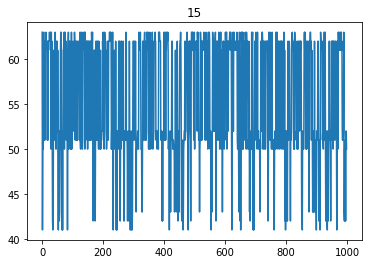

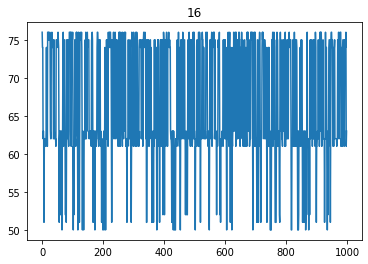

In [63]:
for t1 in range(0, ost16.shape[0]+1):
    plt.plot(each_energy_list[t1])
    plt.title(t1)
    plt.show()

In [64]:
#目標：d-wave nealと同じ結果を出す
y_list_num

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0}